In [ ]:
%load_ext wurlitzer
import atexit
import numpy as np
import open3d as o3d
import pickle
import klampt
import numpy
import time
from klampt.math import se3
from motion_client import MotionClient
from klampt import vis, Geometry3D
from klampt.model import sensing
from motion import *
from OpenGL.GLUT import *
from threading import Thread
from sensorModule2 import Camera_Robot
from klampt import sim
from matplotlib import pyplot as plt
from tqdm import tqdm

# This is just Yifan´s world creation tool - copied it here so I wouldn't have to merge the repos prematurely. 

In [ ]:
from klampt import WorldModel,Geometry3D
from klampt import vis
from klampt.math import so3,se3
import trimesh
import os
import random
import numpy as np
import math

model_path = '../Resources/shared_data/objects/'
mesh_model_path = '../Resources/grasping/models/'

class testingWorldBuilder():
    def __init__(self,floor_length = 20, floor_width = 20,world = []):
        if(world == []):
            self.w = WorldModel()
        else:
            self.w = world
        self.floor =  Geometry3D()
        self.floor.loadFile(model_path+"cube.off")
        self.floor.transform([floor_length,0,0,0,floor_width,0,0,0,0.01],[-floor_length/2.0,-floor_width/2.0,-0.01])
        floor_terrain = self.w.makeTerrain("floor")
        floor_terrain.geometry().set(self.floor)
        floor_terrain.appearance().setColor(0.4,0.3,0.2,1.0)

        ###colors
        self.light_blue = [3.0/255.0, 140.0/255.0, 252.0/255.0,1.0]
        self.wall_green = [50.0/255.0, 168.0/255.0, 143.0/255.0,1.0]
        ###sizes
        self.table_length = 1.2
        self.table_width = 0.8
        self.table_top_thickness = 0.03
        self.table_height = 0.8
        self.leg_width = 0.05
        self.cube_width = 0.05
    def getWorld(self):
        return self.w

    def addTableTopScenario(self,x=0,y=0):
        """
        add a table with objects on top, the center of table can be set
        Parameters:
        --------------
        x,y: floats, the position of the table center
        """

        self.addTable(x,y)
        # add some cubes
        self.addCube((so3.from_axis_angle(([0,0,1],0.5)),[x,y,self.table_height]),self.cube_width,[1.0,0,0,1],1)
        # add one mesh
        self.addRandomMesh([0+x,0.2+y,self.table_height],1)
        self.addRandomMesh([0+x,-0.2+y,self.table_height],2)
        self.addRandomMesh([0.2+x,0+y,self.table_height],3)
        self.addRandomMesh([-0.2+x,-0.2+y,self.table_height],4)

    def addIndoorNavScenario(self):
        """
        Add 4 rooms and a table
        """

        wall_thickness = 0.2
        room_size = [8.0,6.0,4.0]
        self.addRoom(room_size,wall_thickness,T=([1,0,0,0,1,0,0,0,1],[-6,-6,0]),ID = 1 )
        self.addRoom(room_size,wall_thickness,T=([1,0,0,0,1,0,0,0,1],[6,-6,0]),ID = 2 )
        self.addRoom(room_size,wall_thickness,T=(so3.from_axis_angle(([0,0,1],math.pi/1.0)),[6,6,0]),ID = 3 )
        self.addRoom(room_size,wall_thickness,T=(so3.from_axis_angle(([0,0,1],math.pi/1.0)),[-6,6,0]),ID = 4 )
        self.addTable(-6,-6)
        return

    def addRoom(self,room_size = [10.0,8.0,4.0],wall_thickness = 0.2,T=([1,0,0,0,1,0,0,0,1],[0,0,0]),ID = 1 ):
        """
        Add a room to the world
        Parameters:
        -------------------
        room_size = list of 3 floats, the width,depth, and height of the room
        wall_thickess = float
        T:rigid transform of the room
        ID: ID of the room
        """

        #left wall
        self._addTerrain(model_path + "cube.off",se3.mul(T,([wall_thickness,0,0,0,room_size[1]-wall_thickness,0,0,0,room_size[2]],\
            [-room_size[0]/2.0,-room_size[1]/2.0,0])),self.wall_green,"wall1_"+str(ID))
        #wall with window
        self._addTerrain(model_path + "cube.off",se3.mul(T,([room_size[0],0,0,0,wall_thickness,0,0,0,1],\
            [-room_size[0]/2.0,-room_size[1]/2.0,0])),self.wall_green,"wall2_"+str(ID))
        self._addTerrain(model_path + "cube.off",se3.mul(T,([room_size[0],0,0,0,wall_thickness,0,0,0,2],\
            [-room_size[0]/2.0,-room_size[1]/2.0,2])),self.wall_green,"wall3_"+str(ID))
        self._addTerrain(model_path + "cube.off",se3.mul(T,([room_size[0]/2.0-0.5,0,0,0,wall_thickness,0,0,0,1],\
            [-room_size[0]/2.0,-room_size[1]/2.0,1])),self.wall_green,"wall4_"+str(ID))
        self._addTerrain(model_path + "cube.off",se3.mul(T,([room_size[0]/2.0-0.5,0,0,0,wall_thickness,0,0,0,1],\
            [0.5,-room_size[1]/2.0,1])),self.wall_green,"wall5_"+str(ID))

        #right wall
        self._addTerrain(model_path + "cube.off",se3.mul(T,([wall_thickness,0,0,0,room_size[1]-wall_thickness,0,0,0,room_size[2]],\
            [room_size[0]/2.0-wall_thickness,-room_size[1]/2.0,0])),self.wall_green,"wall6_"+str(ID))

        #the wall with door
        self._addTerrain(model_path + "cube.off",se3.mul(T,([room_size[0]-2.5,0,0,0,wall_thickness,0,0,0,room_size[2]],\
            [-room_size[0]/2.0,room_size[1]/2.0-wall_thickness,0])),self.wall_green,"wall7_"+str(ID))
        self._addTerrain(model_path + "cube.off",se3.mul(T,([1,0,0,0,wall_thickness,0,0,0,room_size[2]],\
            [-room_size[0]/2.0+(room_size[0]-1),room_size[1]/2.0-wall_thickness,0])),self.wall_green,"wall8_"+str(ID))
        self._addTerrain(model_path + "cube.off",se3.mul(T,([1.5,0,0,0,wall_thickness,0,0,0,1],\
            [-room_size[0]/2.0+(room_size[0]-1-1.5),room_size[1]/2.0-wall_thickness,3])),self.wall_green,"wall9_"+str(ID))

    ##Functions below add individual objects
    def addCube(self,T,side_length,color,ID,object_mass = 0.1):
        """
        Add a cube to the world.
        Parameters:
        --------------
        T:world transform of the cube
        side_length: float, size of the cube
        color: RGBA values, (0-1)
        ID: int, cannot duplicate
        mass:object mass added at the object geometric center
        """

        self._addRigidObject(model_path + "cube.off",([side_length,0,0,0,side_length,0,0,0,side_length,],[0,0,0]),T,\
            color,object_mass,[side_length/2.0,side_length/2.0,side_length/2.0],"cube"+str(ID))

    def addMesh(self,path,T,color,mass,ID):
        """
        Add a mesh to the world.
        Parameters:
        --------------
        path: path to the mesh file
        T:world transform of the mesh
        color: RGBA values, (0-1)
        mass:object mass added at the object geometric center
        ID: int, cannot duplicate
        """
        mesh = trimesh.load(path)
        mesh_center = mesh.centroid.tolist()

        # load the rigid object in the world
        self._addRigidObject(path,([1,0,0,0,1,0,0,0,1],[0]*3),T,\
            color,mass,mesh_center,"item"+str(ID))

    def addRandomMesh(self,t,ID = 1):
        """
        Add a household item to the world, randonmly selected from the library.
        Color is also determined randomly. Mass set to 1kg arbitrarily
        Parameters:
        --------------
        t:world position of the mesh
        ID: int, cannot duplicate
        """
        meshpaths = []
        for file in os.listdir(mesh_model_path):
            if file.endswith(".ply"):
                meshpaths.append(os.path.join(mesh_model_path, file))

        meshpath = random.choice(meshpaths)
        mesh = trimesh.load(meshpath)
        mesh_center = mesh.centroid.tolist()
        #Z_min = np.min(mesh.vertices[:,2])

        #t[2] = t[2]+mesh_center[2]-Z_min
        # load the rigid object in the world
        self._addRigidObject(meshpath,([1,0,0,0,1,0,0,0,1],[0]*3),([1,0,0,0,1,0,0,0,1],t),\
            (random.random(),random.random(),random.random(),1.0),0.1,mesh_center,"item"+str(ID))

    def addTable(self,x=0,y=0):
        """
        Add a table to the world
        Parameters:
        --------------
        x,y: floats, the x,y position of the center of the table
        """
        table_top = Geometry3D()
        table_leg_1 = Geometry3D()
        table_leg_2 = Geometry3D()
        table_leg_3 = Geometry3D()
        table_leg_4 = Geometry3D()

        table_top.loadFile(model_path + "cube.off")
        table_leg_1.loadFile(model_path + "cube.off")
        table_leg_2.loadFile(model_path + "cube.off")
        table_leg_3.loadFile(model_path + "cube.off")
        table_leg_4.loadFile(model_path + "cube.off")

        table_top.transform([self.table_length,0,0,0,self.table_width,0,0,0,\
            self.table_top_thickness],[0,0,self.table_height - self.table_top_thickness])
        table_leg_1.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height\
            - self.table_top_thickness],[0,0,0])
        table_leg_2.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - \
            self.table_top_thickness],[self.table_length-self.leg_width,0,0])
        table_leg_3.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - 
            self.table_top_thickness],[self.table_length-self.leg_width,self.table_width-self.leg_width,0])
        table_leg_4.transform([self.leg_width,0,0,0,self.leg_width,0,0,0,self.table_height - 
            self.table_top_thickness],[0,self.table_width-self.leg_width,0])

        table_geom = Geometry3D()
        table_geom.setGroup()
        for i,elem in enumerate([table_top,table_leg_1,table_leg_2,table_leg_3,table_leg_4]):
            g = Geometry3D(elem)
            table_geom.setElement(i,g)
        table_geom.transform([1,0,0,0,1,0,0,0,1],[x-self.table_length/2.0,y-self.table_width/2.0,0])
        table = self.w.makeTerrain("table")
        table.geometry().set(table_geom)
        table.appearance().setColor(self.light_blue[0],self.light_blue[1],self.light_blue[2],self.light_blue[3])

    def addRobot(self,path,T):
        """
        Add a robot to the world. You can directly use Klampt functions to add to the world as well
        Parameters:
        ------------
        path: path to the robot model
        T: transform of the base of the robot
        """

        world.loadElement(path)
        item = world.rigidObject(0)
        item.setTransform([1,0,0,0,1,0,0,0,1],[ee_pos[0]-mesh_center[0],ee_pos[1]-mesh_center[1],-Zmin+0.02])

    def _addRigidObject(self,path,T_g,T_p,color,object_mass,Com,name):
        item_1_geom = Geometry3D()
        item_1_geom.loadFile(path) 
        item_1_geom.transform(T_g[0],T_g[1])
        item_1 = self.w.makeRigidObject(name)
        item_1.geometry().set(item_1_geom)
        item_1.appearance().setColor(color[0],color[1],color[2],color[3])
        bmass = item_1.getMass()
        bmass.setMass(object_mass)
        bmass.setCom(Com)
        item_1.setMass(bmass)
        item_1.setTransform(T_p[0],T_p[1])
        return item_1

    def _addTerrain(self,path,T,color,name):
        item_1_geom = Geometry3D()
        item_1_geom.loadFile(path) 
        item_1_geom.transform(T[0],T[1])
        item_1 = self.w.makeTerrain(name)
        item_1.geometry().set(item_1_geom)
        item_1.appearance().setColor(color[0],color[1],color[2],color[3])
        return item_1

# shelf = make_shelf(w,*shelf_dims)
# shelf.geometry().translate((shelf_offset_x,shelf_offset_y,shelf_height))

# vis.add("world",w)
# vis.run()

# help(testingWorldBuilder)


In [ ]:
mode = 'Kinematic'
components = []
robot = MotionClient(address = 'http://localhost:8080')
robot.startServer(mode = mode, components = components,codename = 'anthrax_lowpoly')
startup = True
res = robot.startup()

simrobot = Motion(mode = "Kinematic", codename="anthrax_lowpoly")
rob = './Data'
world = simrobot.getWorld()

builder = testingWorldBuilder(30,30,world = world)
builder.addIndoorNavScenario()
world = builder.getWorld()



In [4]:
crobot = Camera_Robot(robot = robot,world = world)

KrisLibrary::logger(): trying to find logger ODESimulator
  Logger ODESimulator has no appenders. Returning root logger.
Initializing ODE... 
Initializing simulation...
KrisLibrary::logger(): trying to find logger WorldSimulator
  Logger WorldSimulator has no appenders. Returning root logger.
Creating WorldSimulation 
ODERobot: Warning, turning off joint stops on joint 2 (link left_shoulder_link) because of ODE range mismatch 
ODERobot: Warning, turning off joint stops on joint 3 (link left_upperarm_link) because of ODE range mismatch 
ODERobot: Warning, turning off joint stops on joint 4 (link left_forearm_link) because of ODE range mismatch 
ODERobot: Warning, turning off joint stops on joint 5 (link left_wrist1_link) because of ODE range mismatch 
ODERobot: Warning, turning off joint stops on joint 6 (link left_wrist2_link) because of ODE range mismatch 
ODERobot: Warning, turning off joint stops on joint 7 (link left_wrist3_link) because of ODE range mismatch 
ODERobot: Warning, tu

vis: creating GL window
INITIALIZING Qt BACKEND
######### QGLWidget setProgram ###############
#########################################
klampt.vis: Making window 0
#########################################
######### QGLWidget Initialize GL ###############
Visualization thread closing and cleaning up Qt...
######### QGLWidget close ###############


  0%|          | 0/300 [00:00<?, ?it/s]

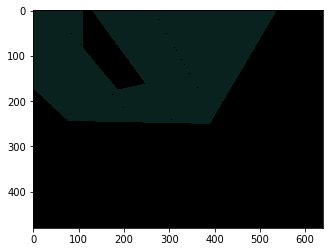

  0%|          | 1/300 [00:00<02:04,  2.39it/s]

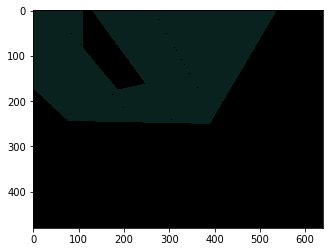

  1%|          | 2/300 [00:00<01:52,  2.65it/s]

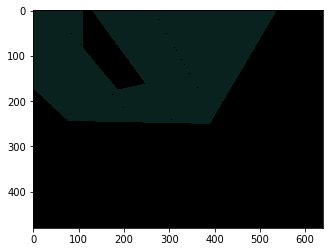

  1%|          | 3/300 [00:01<01:49,  2.71it/s]

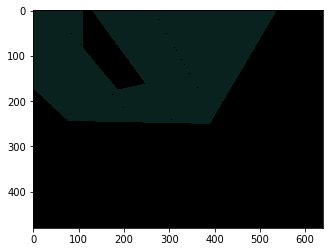

  1%|▏         | 4/300 [00:01<01:41,  2.92it/s]

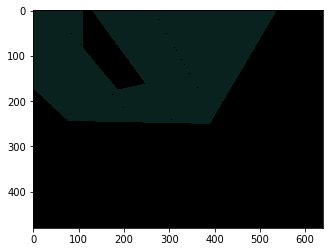

  2%|▏         | 5/300 [00:01<01:40,  2.95it/s]

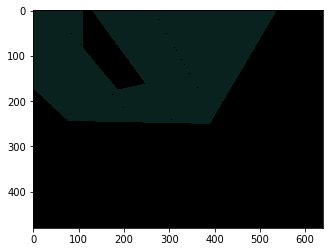

  2%|▏         | 6/300 [00:02<01:39,  2.96it/s]

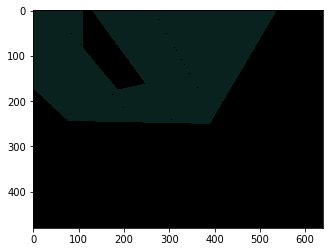

  2%|▏         | 7/300 [00:02<01:38,  2.97it/s]

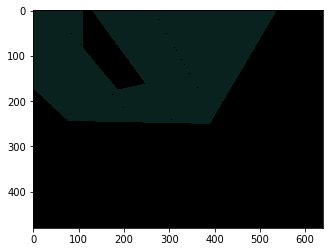

  3%|▎         | 8/300 [00:02<01:38,  2.96it/s]

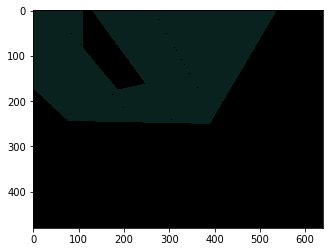

  3%|▎         | 9/300 [00:03<01:37,  2.98it/s]

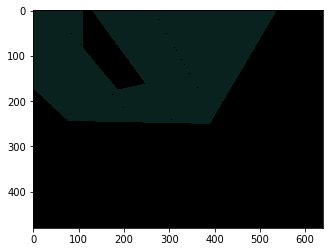

  3%|▎         | 10/300 [00:03<01:35,  3.05it/s]

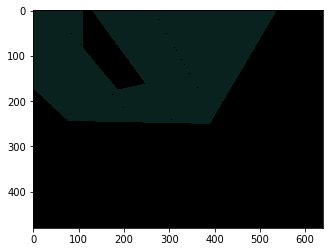

  4%|▎         | 11/300 [00:03<01:35,  3.04it/s]

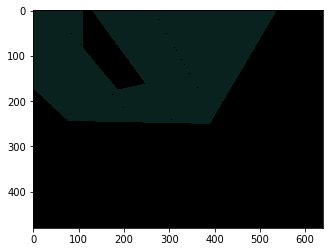

  4%|▍         | 12/300 [00:03<01:34,  3.05it/s]

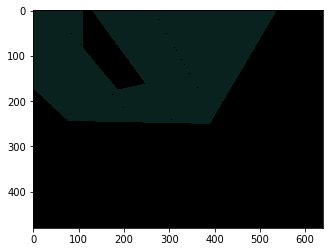

  4%|▍         | 13/300 [00:04<01:34,  3.05it/s]


KeyboardInterrupt: 

In [5]:
%%time
for i in tqdm(range(300)):
    a = crobot.get_rgbd_images()
    plt.imshow(a['realsense_left'][0])
    plt.show()

In [ ]:
a.max()

In [ ]:
a['realsense_left'][0]